In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [3]:
import sys,os
sys.path.append('..')
from backtester import matlab, backtester
from backtester.analysis import *
from backtester.strategy import StrategyBase, OptParam, OptParamArray
from backtester.swarms.ranking import SwarmRanker
from backtester.swarms.rebalancing import SwarmRebalance
from backtester.swarms.filters import SwarmFilter
from backtester.costs import CostsManagerEXOFixed
from backtester.exoinfo import EXOInfo
from backtester.swarms.rankingclasses import *
from backtester.swarms.swarm import Swarm


import pandas as pd
import numpy as np
import scipy

In [4]:
from scripts.settings import *
try:
    from scripts.settings_local import *
except:
    pass

from exobuilder.data.exostorage import EXOStorage

storage = EXOStorage(MONGO_CONNSTR, MONGO_EXO_DB)


exo_filter = '*'     # All 
#exo_filter = 'ES_'  # ES only
exo_filter = ''  # ES Collars (incl Bearish, Bullish, BW and vanilla)

[print(exo) for exo in storage.exo_list(exo_filter)];

ES_BullishCollarBW
ES_BearishCollarBW
ES_CallSpread
ES_PutSpread
ES_ContFut
ZS_BullishCollarBW
ZS_BearishCollarBW
ZS_CallSpread
ZS_PutSpread
ZS_ContFut
CL_BullishCollarBW
CL_BearishCollarBW
CL_CallSpread
CL_PutSpread
CL_ContFut
ZW_BullishCollarBW
ZW_BearishCollarBW
ZW_CallSpread
ZW_PutSpread
ZW_ContFut
ZN_BullishCollarBW
ZN_BearishCollarBW
ZN_CallSpread
ZN_PutSpread
ZN_ContFut
NG_BullishCollarBW
NG_BearishCollarBW
NG_CallSpread
NG_PutSpread
NG_ContFut
ZC_BullishCollarBW
ZC_BearishCollarBW
ZC_CallSpread
ZC_PutSpread
ZC_ContFut
CL_SMART_Ichimoku_Long
ES_SMART_Ichimoku_Long
NG_SMART_Ichimoku_Long
ZC_SMART_Ichimoku_Long
ZS_SMART_Ichimoku_Long
ZW_SMART_Ichimoku_Long
ZN_SMART_Ichimoku_Long
CL_SMART_Ichimoku_VerticalSpread_Bullish
CL_SMART_Ichimoku_Straddle_Bullish
ES_SMART_Ichimoku_Straddle_Bullish
NG_SMART_Ichimoku_Straddle_Bullish
ZC_SMART_Ichimoku_Straddle_Bullish
ZS_SMART_Ichimoku_Straddle_Bullish
ZW_SMART_Ichimoku_Straddle_Bullish
ZN_SMART_Ichimoku_Straddle_Bullish
CL_SmartEXO_Ichi_Bull

In [5]:
class StrategyRenko_BBands_ATRBoxSize(StrategyBase):
    name = 'Renko_BBands_ATRBoxSize'


    def __init__(self, strategy_context):
        # Initialize parent class
        super().__init__(strategy_context)
    
    def calc_entry_rules(self, atr_period, bb_period, bb_k, rules_index):

        box_start = 0
        box_start_idx = None

        box_end = 0
        box_quantity = 0

        temp_l = []

        # Simple renko algorihtm

        df = pd.DataFrame()
        df['close'] = self.data.exo

        O = L = H = C = df['close']

        atr = ATR(H, L, C, atr_period)

        for i in range(len(df)):
            box_size = (atr).shift(1)[i]

            if box_start == 0:
                box_start = df.close[i]

            else:
                box_start = box_start
                price_move = df.close[i] - box_start

                # First of all we need to set box size. 
                # Then calculate price movement. 
                # If price movement is more or equal than box size - renko bar(or bars) will be added

                if np.abs(price_move) >= box_size:

                    # After we calculate box_quantity(price move divided by box size)
                    # This number defines how much renko bars will be registred
                    box_quantity = np.int32(np.floor(np.abs(price_move / box_size)))
                    box_index = df.close.index[i]

                    for b in range(int(box_quantity)):
                    # Let say, index is 2015-01-01, box_start = 100, box_quantity = 3, box size = 10, price move > 0
                    # So renko bar 1 will have next parameters - 
                    # 1)index 2015-01-01
                    # 2)open = 100
                    # 3)close = 110(box_start + box_size)
                    # 4)type = up

                    # Next renko bar will have next parameters -
                    # 1)index 2015-01-01
                    # 2)open = 110(previous renko bar close)
                    # 3)close = 120(open + box_size)
                    # 4)type = up

                    # And so on..

                    # After all we adding renko bars dict to list and convert it to DF

                        if price_move > 0:
                            if box_end == 0:
                                d = {'date': box_index, 'open': box_start, 'close': box_start + box_size, 'type': 'up'}
                                box_end = d['close']
                                temp_l.append(d)

                            else:
                                d = {'date': box_index, 'open': box_end, 'close': box_end + box_size,
                                    'type': 'up'}

                                box_end = d['close']
                                temp_l.append(d)

                        if price_move < 0:
                            if box_end == 0:
                                d = {'date': box_index, 'open': box_start, 'close': box_start - box_size, 'type': 'down'}
                                box_end = d['close']
                                temp_l.append(d)

                            else:           
                                d = {'date': box_index, 'open': box_end, 'close': box_end - box_size, 
                                     'type': 'down'}

                                box_end = d['close']
                                temp_l.append(d)

                    box_start = df.close[i]

        renko_df = pd.DataFrame(temp_l)

        del temp_l

        #df = pd.DataFrame()

        #
        # ??????????????????????
        #df['renkoclose'] = renko_df.set_index('date').close
        #df['renkoclose'] = renko_df.close
        #df['date'] = renko_df.date
        # ??????????????????????
        #
        
        signals_df = pd.DataFrame()
        signals_df['exo'] = self.data.exo
        
        if rules_index >= 14:

            for i in range(10, 100, 10):
                bb_period = i
                bb_k = bb_k
                renko_df['bb_central_line' + str(i)] = renko_df.close.rolling(bb_period).mean()
                renko_df['bb_upperband' + str(i)] = renko_df['bb_central_line' + str(i)] + (
                bb_k * renko_df['bb_central_line' + str(i)].rolling(bb_period).std())
                renko_df['bb_lowerband' + str(i)] = renko_df['bb_central_line' + str(i)] - (
                bb_k * renko_df['bb_central_line' + str(i)].rolling(bb_period).std())

            renko_df['bb_multiperiod_central_line'] = renko_df.filter(like='centr').mean(axis=1)
            renko_df['bb_multiperiod_upperband'] = renko_df.filter(like='upper').mean(axis=1)
            renko_df['bb_multiperiod_lowerband'] = renko_df.filter(like='lower').mean(axis=1)

            renko_df['bb_multiperiod_%b'] = (renko_df.close - renko_df['bb_multiperiod_lowerband']) / (
                                        renko_df['bb_multiperiod_upperband'] - renko_df['bb_multiperiod_lowerband'])

            renko_df['bb_multiperiod_%b_pctrank'] = renko_df['bb_multiperiod_%b'].rank(pct=True)

            renko_df['bb_multiperiod_width'] = (renko_df['bb_multiperiod_upperband'] - renko_df['bb_multiperiod_lowerband'])

            renko_df['bb_multiperiod_width_pctrank'] = renko_df['bb_multiperiod_width'].rank(pct=True)

        if rules_index <= 13:
            bb_period = bb_period
            bb_k = bb_k
            renko_df['bb_central_line'] = renko_df.close.rolling(bb_period).mean()
            renko_df['bb_upperband'] = renko_df.bb_central_line + (bb_k * renko_df.bb_central_line.rolling(bb_period).std())
            renko_df['bb_lowerband'] = renko_df.bb_central_line - (bb_k * renko_df.bb_central_line.rolling(bb_period).std())

            renko_df['bb_%b'] = (renko_df.close - renko_df['bb_lowerband']) / (renko_df['bb_upperband'] - renko_df['bb_lowerband'])
            renko_df['bb_width'] = (renko_df['bb_upperband'] - renko_df['bb_lowerband'])

            renko_df['bb_width_pctrank'] = renko_df.bb_width.rank(pct=True)
            renko_df['bb_%b_pctrank'] = renko_df['bb_%b'].rank(pct=True)
        # Trend 0:5
        # Vola breakout 5:10
        # High vola(BBands width percent rank > 80-90) 10:15
        # %B rules 15:26
        if rules_index == 0:
            up_trend = (((renko_df.close - renko_df.bb_upperband).rolling(10).median()) <= (renko_df.close - renko_df.bb_upperband))
            
            renko_df['entry_signal']  = up_trend
            signals_df = signals_df.join(renko_df.set_index('date')['entry_signal'])
            signals_df = signals_df.fillna(False).groupby(signals_df.index).any()
            
            return signals_df.entry_signal

        if rules_index == 1:
            down_trend = (renko_df.bb_lowerband - renko_df.close).rolling(10).median() <= (renko_df.bb_lowerband - renko_df.close)

            renko_df['entry_signal']  = down_trend
            signals_df = signals_df.join(renko_df.set_index('date')['entry_signal'])
            signals_df = signals_df.fillna(False).groupby(signals_df.index).any()
            
            return signals_df.entry_signal

        if rules_index == 2:
            bb_width_pctrank_less_20 = renko_df.bb_width_pctrank <= 0.2

            renko_df['entry_signal']  = bb_width_pctrank_less_20
            signals_df = signals_df.join(renko_df.set_index('date')['entry_signal'])
            signals_df = signals_df.fillna(False).groupby(signals_df.index).any()
            
            return signals_df.entry_signal

        if rules_index == 3:
            bb_width_pctrank_less_10 = renko_df.bb_width_pctrank <= 0.1

            renko_df['entry_signal']  = bb_width_pctrank_less_10
            signals_df = signals_df.join(renko_df.set_index('date')['entry_signal'])
            signals_df = signals_df.fillna(False).groupby(signals_df.index).any()
            
            return signals_df.entry_signal

        if rules_index == 4:
            bb_width_pctrank_more_80 = renko_df.bb_width_pctrank >= 0.8

            renko_df['entry_signal']  = bb_width_pctrank_more_80
            signals_df = signals_df.join(renko_df.set_index('date')['entry_signal'])
            signals_df = signals_df.fillna(False).groupby(signals_df.index).any()
            
            return signals_df.entry_signal

        if rules_index == 5:
            bb_width_pctrank_more_90 = renko_df.bb_width_pctrank >= 0.9

            renko_df['entry_signal']  = bb_width_pctrank_more_90
            signals_df = signals_df.join(renko_df.set_index('date')['entry_signal'])
            signals_df = signals_df.fillna(False).groupby(signals_df.index).any()
            
            return signals_df.entry_signal

        if rules_index == 6:
            bb_width_pctrank_more_50 = renko_df.bb_width_pctrank >= 0.5

            renko_df['entry_signal']  = bb_width_pctrank_more_50 
            signals_df = signals_df.join(renko_df.set_index('date')['entry_signal'])
            signals_df = signals_df.fillna(False).groupby(signals_df.index).any()
            
            return signals_df.entry_signal

        if rules_index == 7:
            bb_width_pctrank_less_50 = renko_df.bb_width_pctrank <= 0.5

            renko_df['entry_signal']  = bb_width_pctrank_less_50
            signals_df = signals_df.join(renko_df.set_index('date')['entry_signal'])
            signals_df = signals_df.fillna(False).groupby(signals_df.index).any()
            
            return signals_df.entry_signal

        if rules_index == 8:
            bb_pctb_pctrank_less_20 = renko_df['bb_%b_pctrank'] <= 0.2

            renko_df['entry_signal']  = bb_pctb_pctrank_less_20
            signals_df = signals_df.join(renko_df.set_index('date')['entry_signal'])
            signals_df = signals_df.fillna(False).groupby(signals_df.index).any()
            
            return signals_df.entry_signal

        if rules_index == 9:
            bb_pctb_pctrank_less_10 = renko_df['bb_%b_pctrank'] <= 0.1

            renko_df['entry_signal']  = bb_pctb_pctrank_less_10
            signals_df = signals_df.join(renko_df.set_index('date')['entry_signal'])
            signals_df = signals_df.fillna(False).groupby(signals_df.index).any()
            
            return signals_df.entry_signal

        if rules_index == 10:
            bb_pctb_pctrank_more_80 = renko_df['bb_%b_pctrank'] >= 0.8

            renko_df['entry_signal']  = bb_pctb_pctrank_more_80
            signals_df = signals_df.join(renko_df.set_index('date')['entry_signal'])
            signals_df = signals_df.fillna(False).groupby(signals_df.index).any()
            
            return signals_df.entry_signal

        if rules_index == 11:
            bb_pctb_pctrank_more_90 = renko_df['bb_%b_pctrank'] <= 0.9

            renko_df['entry_signal']  = bb_pctb_pctrank_more_90
            signals_df = signals_df.join(renko_df.set_index('date')['entry_signal'])
            signals_df = signals_df.fillna(False).groupby(signals_df.index).any()
            
            return signals_df.entry_signal

        if rules_index == 12:
            bb_pctb_pctrank_more_50 = renko_df['bb_%b_pctrank'] >= 0.5

            renko_df['entry_signal']  = bb_pctb_pctrank_more_50
            signals_df = signals_df.join(renko_df.set_index('date')['entry_signal'])
            signals_df = signals_df.fillna(False).groupby(signals_df.index).any()
            
            return signals_df.entry_signal

        if rules_index == 13:
            bb_pctb_pctrank_less_50 = renko_df['bb_%b_pctrank'] <= 0.5

            renko_df['entry_signal']  = bb_pctb_pctrank_less_50
            signals_df = signals_df.join(renko_df.set_index('date')['entry_signal'])
            signals_df = signals_df.fillna(False).groupby(signals_df.index).any()
            
            return signals_df.entry_signal

        if rules_index == 14:
            multiperiod_up_trend = ((renko_df.close - renko_df.bb_multiperiod_upperband).rolling(10).median()) <= (
                                renko_df.close - renko_df.bb_multiperiod_upperband)

            renko_df['entry_signal']  = multiperiod_up_trend
            signals_df = signals_df.join(renko_df.set_index('date')['entry_signal'])
            signals_df = signals_df.fillna(False).groupby(signals_df.index).any()
            
            return signals_df.entry_signal

        if rules_index == 15:
            multiperiod_down_trend = (renko_df.bb_multiperiod_lowerband - renko_df.close).rolling(10).median() <= (
                                    renko_df.bb_multiperiod_lowerband - renko_df.close)

            renko_df['entry_signal']  = multiperiod_down_trend
            signals_df = signals_df.join(renko_df.set_index('date')['entry_signal'])
            signals_df = signals_df.fillna(False).groupby(signals_df.index).any()
            
            return signals_df.entry_signal

        if rules_index == 16:
            bb_multiperiod_width_pctrank_less_20 = renko_df.bb_multiperiod_width_pctrank <= 0.2

            renko_df['entry_signal']  = bb_multiperiod_width_pctrank_less_20
            signals_df = signals_df.join(renko_df.set_index('date')['entry_signal'])
            signals_df = signals_df.fillna(False).groupby(signals_df.index).any()
            
            return signals_df.entry_signal

        if rules_index == 17:
            bb_multiperiod_width_pctrank_less_10 = renko_df.bb_multiperiod_width_pctrank <= 0.1

            renko_df['entry_signal']  = bb_multiperiod_width_pctrank_less_10
            signals_df = signals_df.join(renko_df.set_index('date')['entry_signal'])
            signals_df = signals_df.fillna(False).groupby(signals_df.index).any()
            
            return signals_df.entry_signal

        if rules_index == 18:
            bb_multiperiod_width_pctrank_more_80 = renko_df.bb_multiperiod_width_pctrank >= 0.8

            renko_df['entry_signal']  = bb_multiperiod_width_pctrank_more_80
            signals_df = signals_df.join(renko_df.set_index('date')['entry_signal'])
            signals_df = signals_df.fillna(False).groupby(signals_df.index).any()
            
            return signals_df.entry_signal

        if rules_index == 19:
            bb_multiperiod_width_pctrank_more_90 = renko_df.bb_multiperiod_width_pctrank <= 0.9

            renko_df['entry_signal']  = bb_multiperiod_width_pctrank_more_90
            signals_df = signals_df.join(renko_df.set_index('date')['entry_signal'])
            signals_df = signals_df.fillna(False).groupby(signals_df.index).any()
            
            return signals_df.entry_signal

        if rules_index == 20:
            bb_multiperiod_width_pctrank_more_50 = renko_df.bb_multiperiod_width_pctrank >= 0.5

            renko_df['entry_signal']  = bb_multiperiod_width_pctrank_more_50
            signals_df = signals_df.join(renko_df.set_index('date')['entry_signal'])
            signals_df = signals_df.fillna(False).groupby(signals_df.index).any()
            
            return signals_df.entry_signal

        if rules_index == 21:
            bb_multiperiod_width_pctrank_less_50 = renko_df.bb_multiperiod_width_pctrank <= 0.5

            renko_df['entry_signal']  = bb_multiperiod_width_pctrank_less_50
            signals_df = signals_df.join(renko_df.set_index('date')['entry_signal'])
            signals_df = signals_df.fillna(False).groupby(signals_df.index).any()
            
            return signals_df.entry_signal

        if rules_index == 22:
            bb_multiperiod_pctb_pctrank_less_20 = renko_df['bb_multiperiod_%b_pctrank'] <= 0.2

            renko_df['entry_signal']  = bb_multiperiod_pctb_pctrank_less_20
            signals_df = signals_df.join(renko_df.set_index('date')['entry_signal'])
            signals_df = signals_df.fillna(False).groupby(signals_df.index).any()
            
            return signals_df.entry_signal

        if rules_index == 23:
            bb_multiperiod_pctb_pctrank_less_10 = renko_df['bb_multiperiod_%b_pctrank'] <= 0.1

            renko_df['entry_signal']  = bb_multiperiod_pctb_pctrank_less_10
            signals_df = signals_df.join(renko_df.set_index('date')['entry_signal'])
            signals_df = signals_df.fillna(False).groupby(signals_df.index).any()
            
            return signals_df.entry_signal

        if rules_index == 24:
            bb_multiperiod_pctb_pctrank_more_80 = renko_df['bb_multiperiod_%b_pctrank'] >= 0.8

            renko_df['entry_signal']  = bb_multiperiod_pctb_pctrank_more_80
            signals_df = signals_df.join(renko_df.set_index('date')['entry_signal'])
            signals_df = signals_df.fillna(False).groupby(signals_df.index).any()
            
            return signals_df.entry_signal

        if rules_index == 25:
            bb_multiperiod_pctb_pctrank_more_90 = renko_df['bb_multiperiod_%b_pctrank'] <= 0.9

            renko_df['entry_signal']  = bb_multiperiod_pctb_pctrank_more_90
            signals_df = signals_df.join(renko_df.set_index('date')['entry_signal'])
            signals_df = signals_df.fillna(False).groupby(signals_df.index).any()
            
            return signals_df.entry_signal

        if rules_index == 26:
            bb_multiperiod_pctb_pctrank_more_50 = renko_df['bb_multiperiod_%b_pctrank'] >= 0.5

            renko_df['entry_signal']  = bb_multiperiod_pctb_pctrank_more_50
            signals_df = signals_df.join(renko_df.set_index('date')['entry_signal'])
            signals_df = signals_df.fillna(False).groupby(signals_df.index).any()
            
            return signals_df.entry_signal

        if rules_index == 27:
            bb_multiperiod_pctb_pctrank_less_50 = renko_df['bb_multiperiod_%b_pctrank'] <= 0.5

            renko_df['entry_signal']  = bb_multiperiod_pctb_pctrank_less_50
            signals_df = signals_df.join(renko_df.set_index('date')['entry_signal'])
            signals_df = signals_df.fillna(False).groupby(signals_df.index).any()
            
            return signals_df.entry_signal


        if rules_index > 27:
            raise ValueError('Rules index parameter must be in range of 0-27')
            
        
        
    def calc_exit_rules(self, atr_period, period_median, exit_rules_index):

        box_start = 0
        box_start_idx = None

        box_end = 0
        box_quantity = 0

        temp_l = []

        # Simple renko algorihtm

        df = pd.DataFrame()
        df['close'] = self.data.exo

        O = L = H = C = df['close']

        atr = ATR(H, L, C, atr_period)

        for i in range(len(df)):
            box_size = (atr).shift(1)[i]

            if box_start == 0:
                box_start = df.close[i]

            else:
                box_start = box_start
                price_move = df.close[i] - box_start

                # First of all we need to set box size. 
                # Then calculate price movement. 
                # If price movement is more or equal than box size - renko bar(or bars) will be added

                if np.abs(price_move) >= box_size:

                    # After we calculate box_quantity(price move divided by box size)
                    # This number defines how much renko bars will be registred
                    box_quantity = np.int32(np.floor(np.abs(price_move / box_size)))
                    box_index = df.close.index[i]

                    for b in range(int(box_quantity)):
                    # Let say, index is 2015-01-01, box_start = 100, box_quantity = 3, box size = 10, price move > 0
                    # So renko bar 1 will have next parameters - 
                    # 1)index 2015-01-01
                    # 2)open = 100
                    # 3)close = 110(box_start + box_size)
                    # 4)type = up

                    # Next renko bar will have next parameters -
                    # 1)index 2015-01-01
                    # 2)open = 110(previous renko bar close)
                    # 3)close = 120(open + box_size)
                    # 4)type = up

                    # And so on..

                    # After all we adding renko bars dict to list and convert it to DF

                        if price_move > 0:
                            if box_end == 0:
                                d = {'date': box_index, 'open': box_start, 'close': box_start + box_size, 'type': 'up'}
                                box_end = d['close']
                                temp_l.append(d)

                            else:
                                d = {'date': box_index, 'open': box_end, 'close': box_end + box_size,
                                    'type': 'up'}

                                box_end = d['close']
                                temp_l.append(d)

                        if price_move < 0:
                            if box_end == 0:
                                d = {'date': box_index, 'open': box_start, 'close': box_start - box_size, 'type': 'down'}
                                box_end = d['close']
                                temp_l.append(d)

                            else:           
                                d = {'date': box_index, 'open': box_end, 'close': box_end - box_size, 
                                     'type': 'down'}

                                box_end = d['close']
                                temp_l.append(d)

                    box_start = df.close[i]

        renko_df = pd.DataFrame(temp_l)

        del temp_l

        trailing_stop = renko_df.close.rolling(period_median).median().shift(1)
        
        if exit_rules_index == 0:
            renko_df['exit_signal']  = CrossDown(renko_df.close, trailing_stop)
            df = df.join(renko_df.set_index('date')['exit_signal'])
            df = df.fillna(False).groupby(df.index).any()
            
            return df.exit_signal
        
        elif exit_rules_index == 1:
            renko_df['exit_signal']  = CrossUp(renko_df.close, trailing_stop)
            df = df.join(renko_df.set_index('date')['exit_signal'])
            df = df.fillna(False).groupby(df.index).any()
            
            return df.exit_signal
        
    def calculate(self, params=None, save_info=False):
    #
    #
    #  Params is a tripple like (50, 10, 15), where:
    #   50 - slow MA period
    #   10 - fast MA period
    #   15 - median period
    #
    #  On every iteration of swarming algorithm, parameter set will be different.
    #  For more information look inside: /notebooks/tmp/Swarming engine research.ipynb
    #

        if params is None:
            # Return default parameters
            direction, atr_period, bb_period, bb_k, rules_index, exit_rules_index, period_median = self.default_opts()
        else:
            # Unpacking optimization params
            #  in order in self.opts definition
            direction, atr_period, bb_period, bb_k, rules_index, exit_rules_index, period_median = params

        # Defining EXO price
        px = self.data.exo

        # Median based trailing stop
        trailing_stop = px.rolling(period_median).median().shift(1)

        # Enry/exit rules
        entry_rule = self.calc_entry_rules(atr_period, bb_period, bb_k, rules_index)

        if direction == 1:
            #exit_rule = (CrossDown(px, trailing_stop))  # Cross down for longs
            exit_rule = self.calc_exit_rules(atr_period, period_median, exit_rules_index)
            # exit_rule = pd.Series(rules_list[exit_rules_index])
        elif direction == -1:
            exit_rule = self.calc_exit_rules(atr_period, period_median, exit_rules_index)
            #exit_rule = (CrossUp(px, trailing_stop))  # Cross up for shorts, Cross down for longs
            
        # Swarm_member_name must be *unique* for every swarm member
        # We use params values for uniqueness
        swarm_member_name = self.get_member_name(params)

        #
        # Calculation info
        #
        calc_info = None
        if save_info:
            calc_info = {'trailing_stop': trailing_stop}

        return swarm_member_name, entry_rule, exit_rule, calc_info

In [6]:
StrategyRenko_BBands_ATRBoxSize

__main__.StrategyRenko_BBands_ATRBoxSize

## Script settings

In [7]:
STRATEGY_CONTEXT = {
    'strategy': { 
        'class': StrategyRenko_BBands_ATRBoxSize,
        'exo_name': 'CL_SmartEXO_Ichi_Bullish_Straddle_150Delta_ExpHedged',# <---- Select and paste EXO name from cell above
        'exo_storage': storage,          
        'opt_params': [
                        #OptParam(name, default_value, min_value, max_value, step)
                        OptParamArray('Direction', [1]),
                        OptParamArray('ATR period', [10, 100]),
                        OptParam('BB_Period', 20, 50, 50, 50),
                        OptParam('BB_K', 2, 8, 8, 1),
            
                        ### Trend 0:5
                        #OptParamArray('RulesIndex', np.arange(27)[0:5]),
            
                        ### Vola breakout 5:10
                        #OptParamArray('RulesIndex', np.arange(27)[5:10]),
        
                        ### High vola(BBands width percent rank > 80-90) 10:15
                        #OptParamArray('RulesIndex', np.arange(27)[10:15]),
            
                        ### %B rules 15:26
                        OptParamArray('RulesIndex', np.arange(27)[18:22]),
            
                        ### All rules
                        #OptParamArray('RulesIndex', np.arange(27)[:]),
                        
            OptParamArray('Exit_rules_index', np.arange(2)),
                        OptParam('MedianPeriod', 5, 100, 130, 10)
            
            ],
    },
    'swarm': {
        'members_count': 2,
        'ranking_class': RankerBestWithCorrel(window_size=-1, correl_threshold=0.5),
        'rebalance_time_function': SwarmRebalance.every_friday,

    },
    'costs':{
        'manager': CostsManagerEXOFixed,
        'context': {
            'costs_options': 3.0,
            'costs_futures': 3.0,
        }
    }
}

# Backtest class based strategy

In [8]:
smgr = Swarm(STRATEGY_CONTEXT)
smgr.run_swarm()
smgr.pick()

# Saving results to swarms directory
smgr.save('./swarms/')

### WARNING! Loading swarm from file (don't run next cell if you want new swarm instance)

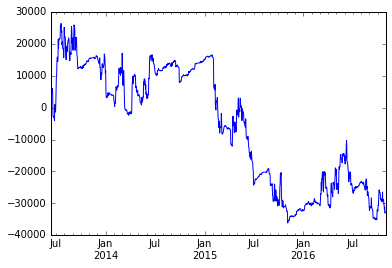

In [9]:
smgr.strategy.data.exo.plot()

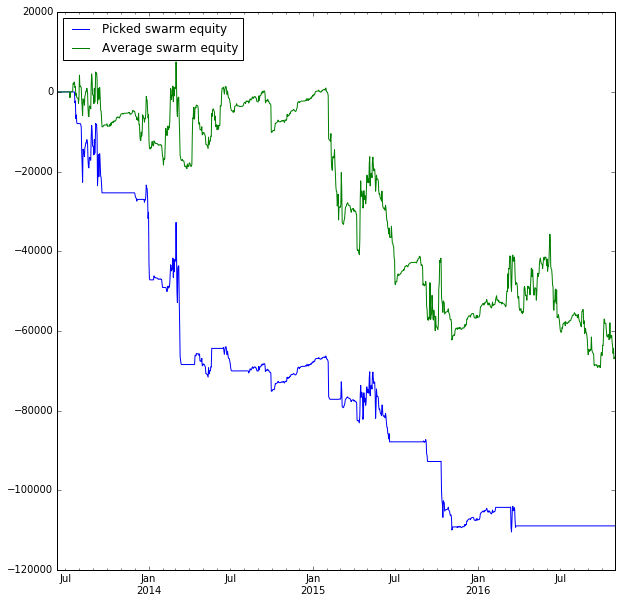

In [10]:
figsize(10,10)
smgr.picked_equity.plot(label='Picked swarm equity');
smgr.raw_equity.plot(label='Average swarm equity');
legend(loc=2);

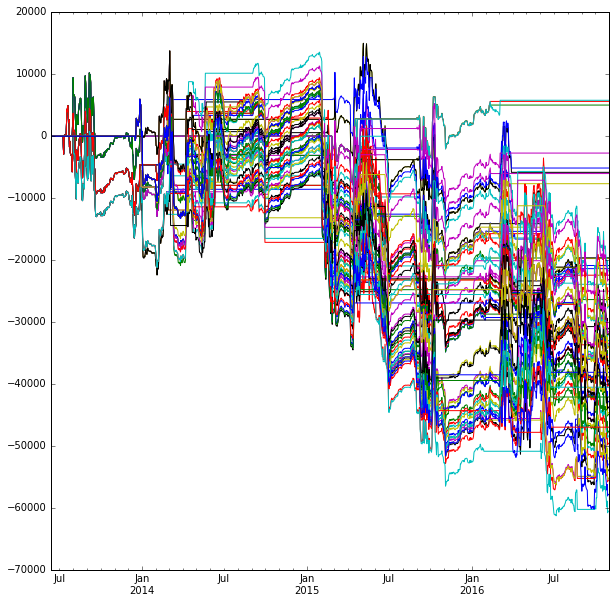

In [11]:
smgr.raw_swarm.plot(legend=False)

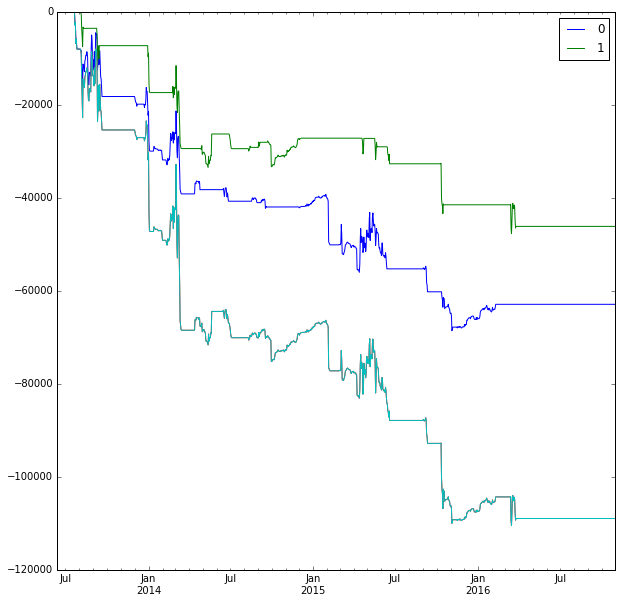

In [12]:
smgr.picked_swarm.plot()

smgr.picked_swarm.sum(1).plot(label='smgr.picked_swarm-sum')
smgr.picked_equity.plot(label='Picked swarm equity')

# Swarm exposure

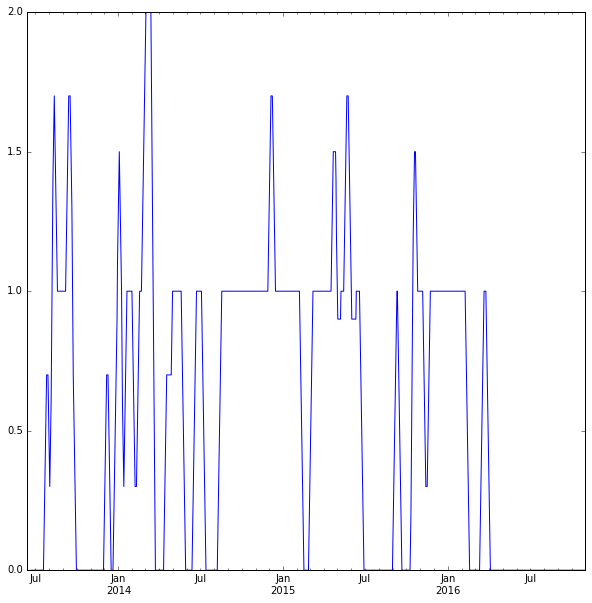

In [13]:
smgr.picked_exposure.sum(axis=1).rolling(10).mean().plot()

# Swarm statistics

#### Non-picked swarm stats

In [14]:
smgr.picked_stats

{'note:Not implemented yet'}

## Exo information

In [15]:
smgr.strategy.exoinfo.exo_info

{'dbdata': {'_id': ObjectId('5817a3be20bb1d0dfe613ad7'),
  'name': 'CL_SmartEXO_Ichi_Bullish_Straddle_150Delta_ExpHedged',
  'position': {'_realized_pnl': -32760.269478895683,
   'positions': {'203171332': {'leg_name': 'bullish',
     'qty': 4.0,
     'value': 8447.759531573965},
    '203179171': {'leg_name': '', 'qty': -2.0, 'value': -352.1255013551734},
    '203183071': {'leg_name': '', 'qty': -4.0, 'value': -1008.598230725159},
    '203183077': {'leg_name': '', 'qty': 2.0, 'value': 1954.325203646441}}},
  'series': b'\x80\x03cpandas.core.frame\nDataFrame\nq\x00)\x81q\x01}q\x02(X\t\x00\x00\x00_metadataq\x03]q\x04X\x04\x00\x00\x00_typq\x05X\t\x00\x00\x00dataframeq\x06X\x05\x00\x00\x00_dataq\x07cpandas.core.internals\nBlockManager\nq\x08)\x81q\t(]q\n(cpandas.indexes.base\n_new_Index\nq\x0bcpandas.indexes.base\nIndex\nq\x0c}q\r(X\x04\x00\x00\x00dataq\x0ecnumpy.core.multiarray\n_reconstruct\nq\x0fcnumpy\nndarray\nq\x10K\x00\x85q\x11C\x01bq\x12\x87q\x13Rq\x14(K\x01K\x01\x85q\x15cnumpy\ndt

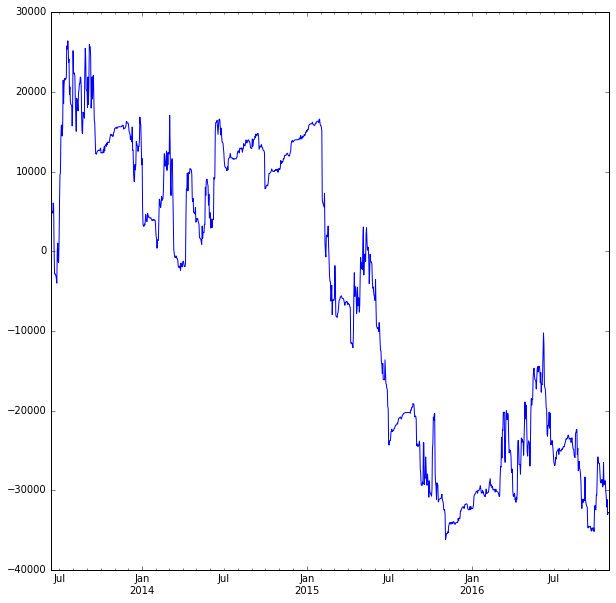

In [16]:
smgr.strategy.exoinfo.data.exo.plot()

### Global filter information (obsolete)


## Costs information (per 1-exo unit)

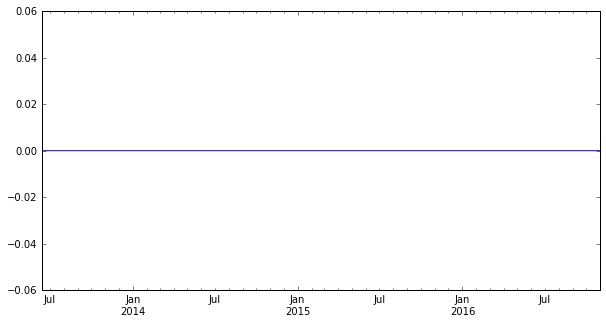

In [17]:
figsize(10,5)
smgr.strategy.costs.plot()

## Margin graphs

### EXO Margin (per 1 EXO unit)

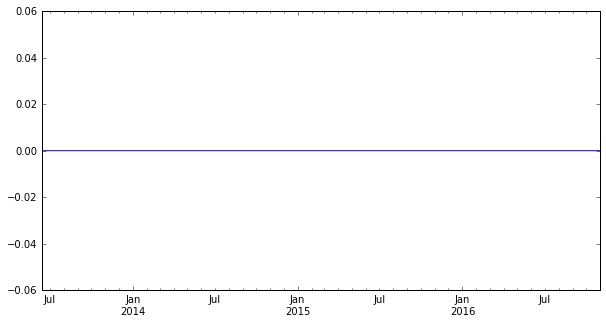

In [18]:
smgr.strategy.exoinfo.margin().plot()

# Saving results

In [19]:
smgr.save('./swarms/')

In [20]:
smgr.raw_swarm#.plot()

,"(1, 10, 50, 8, 18, 0, 100)","(1, 10, 50, 8, 18, 0, 110)","(1, 10, 50, 8, 18, 0, 120)","(1, 10, 50, 8, 18, 0, 130)","(1, 10, 50, 8, 18, 1, 100)","(1, 10, 50, 8, 18, 1, 110)","(1, 10, 50, 8, 18, 1, 120)","(1, 10, 50, 8, 18, 1, 130)","(1, 10, 50, 8, 19, 0, 100)","(1, 10, 50, 8, 19, 0, 110)",...,"(1, 100, 50, 8, 20, 1, 120)","(1, 100, 50, 8, 20, 1, 130)","(1, 100, 50, 8, 21, 0, 100)","(1, 100, 50, 8, 21, 0, 110)","(1, 100, 50, 8, 21, 0, 120)","(1, 100, 50, 8, 21, 0, 130)","(1, 100, 50, 8, 21, 1, 100)","(1, 100, 50, 8, 21, 1, 110)","(1, 100, 50, 8, 21, 1, 120)","(1, 100, 50, 8, 21, 1, 130)"
2013-06-13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-06-14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-06-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-06-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-06-17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-06-18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-06-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-06-20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-06-21,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-06-22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
